In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

features = ['Cu', 'Pb', 'Zn', 'Ni', 'Co', 'Sb', 'As', 'Ag', 'Au']
pos = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
neg = pd.read_csv("/content/drive/My Drive/negative_samples.csv").select_dtypes(include=np.number)
pos.columns, neg.columns = pos.columns.str.strip(), neg.columns.str.strip()

X = np.vstack([pos[features].values, neg[features].values])
y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])

# Scale features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
display(X_pca_2d[:21])

array([[ 3.91861668, -2.37802894],
       [ 1.20207347,  0.82566114],
       [ 0.36868306, -0.91879327],
       [ 0.27917129,  0.97431997],
       [-0.4256963 ,  1.06179184],
       [ 1.72186787, -0.80245444],
       [-0.63146831,  1.26842273],
       [ 9.4629513 ,  1.22333627],
       [-0.79432752, -0.98070613],
       [ 3.35349731, -2.20386026],
       [ 5.89683771, -1.42933058],
       [-0.23459721,  0.51679828],
       [-0.01855045,  4.34950651],
       [ 0.0935059 ,  1.50191253],
       [ 0.32579053,  0.65479128],
       [-0.18896255,  0.8514333 ],
       [-0.49887632,  2.61487424],
       [ 0.35501146,  1.85104441],
       [-0.22700345,  2.64073964],
       [ 0.02354569,  1.30250016],
       [-0.6287729 ,  0.7934199 ]])

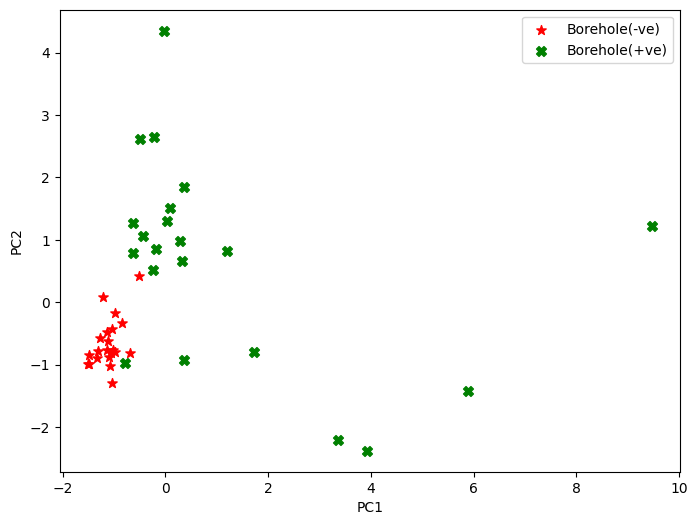

In [ ]:
# Assuming X_scaled is already defined and scaled features are ready from previous steps
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data = X_pca_2d, columns = ['principal component 1', 'principal component 2'])
pca_df['target'] = y

# Plotting the 2D PCA
plt.figure(figsize=(8, 6))
targets = [0, 1]
colors = ['r', 'g']
markers = ['*', 'X']
for target, color, marker in zip(targets,colors, markers):
    indicesToKeep = pca_df['target'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , marker=marker
               , s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('')
plt.legend(['Borehole(-ve)', 'Borehole(+ve)'])
#plt.grid()
# Save the figure with 600 dpi
plt.savefig("PCA.png", dpi=600)

plt.show()

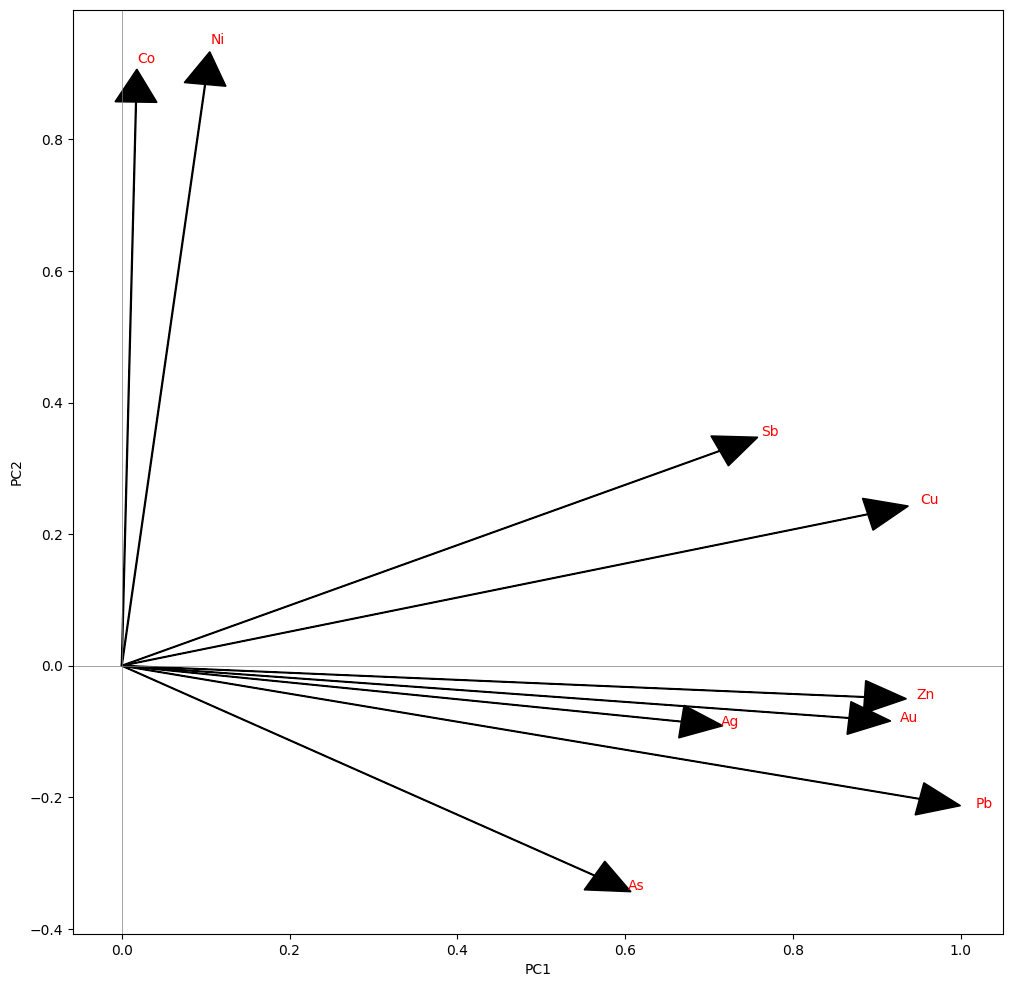

In [ ]:
# Assuming pca is already fitted from the previous PCA analysis
# and features are defined in a previous cell
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.05, color='black')
    plt.text(loadings[i, 0]*1.07, loadings[i, 1]*1.07, feature, color='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('')
#plt.grid()
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
# Save the figure with 600 dpi
plt.savefig("LoadingPCA.png", dpi=600)

plt.show()

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train Accuracy: 0.966, Test Accuracy: 0.846
Train AUC: 0.957, Test AUC: 1.000


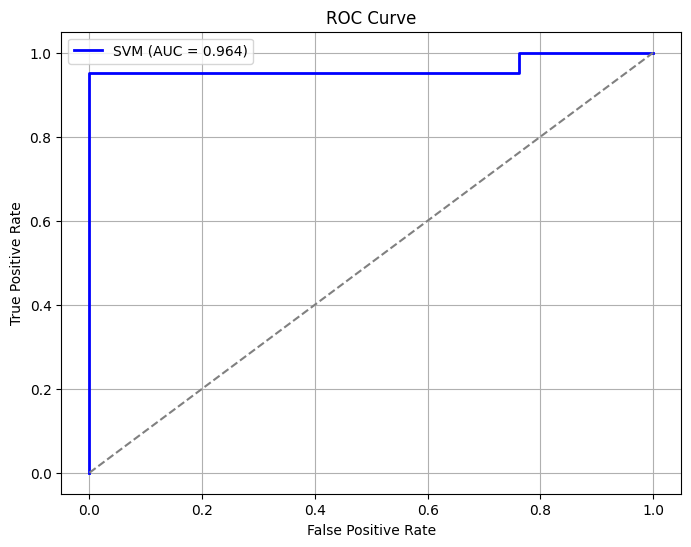

   Latitude  Longitude      Cu       Pb     Zn      Ni     Co      Sb      As  \
0    14.284     76.406  208.75  3675.60  711.3   58.13  30.00  400.63  5281.3   
1    14.281     76.409  121.67   468.17  410.8  103.83  49.67  131.50  2470.7   
2    14.278     76.412   96.15   183.65  248.5   67.31  34.04   79.81  1131.2   
3    14.289     76.408  194.25    36.58  142.3  115.00  37.25   31.50  1020.0   
4    14.289     76.404  127.17    37.83  137.0   94.33  48.83   33.46   187.8   

      Ag    Au  Prospectivity  
0  45.63  4.48       0.989514  
1  65.00  2.59       0.976845  
2  85.00  1.80       0.769882  
3  51.42  1.32       0.980566  
4  51.42  0.69       0.718620  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['Cu', 'Pb', 'Zn', 'Ni', 'Co', 'Sb', 'As', 'Ag', 'Au']
pos = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
neg = pd.read_csv("/content/drive/My Drive/negative_samples.csv").select_dtypes(include=np.number)
pos.columns, neg.columns = pos.columns.str.strip(), neg.columns.str.strip()

X = np.vstack([pos[features].values, neg[features].values])
y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])

# Scale features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally add noise (try reducing or disabling if harmful)
np.random.seed(42)
noise = np.random.normal(0, 0.3, X_scaled.shape)
X_noisy = X_scaled + noise

# PCA keeping 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_noisy)

# Train/test split stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

# Expanded SVM hyperparameter grid
param_grid = {
    'C': [100],
    'gamma': [0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")

svm_model = grid.best_estimator_

# Evaluate train and test set
y_train_prob = svm_model.predict_proba(X_train)[:, 1]
y_test_prob = svm_model.predict_proba(X_test)[:, 1]
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

print(f"Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")
print(f"Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")

fpr_total, tpr_total, _ = roc_curve(np.concatenate([y_train, y_test]), svm_model.predict_proba(np.vstack([X_train, X_test]))[:, 1])

plt.figure(figsize=(8,6))
plt.plot(fpr_total, tpr_total, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_score(np.concatenate([y_train, y_test]), svm_model.predict_proba(np.vstack([X_train, X_test]))[:, 1]):.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Predict on grid for prospectivity map
grid_df = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
grid_df.columns = grid_df.columns.str.strip()
grid_features = scaler.transform(grid_df[features].values)
grid_features_noisy = grid_features + np.random.normal(0, 0.3, grid_features.shape)
grid_features_pca = pca.transform(grid_features_noisy)
grid_probs = svm_model.predict_proba(grid_features_pca)[:, 1]
grid_df['Prospectivity'] = grid_probs
grid_df.to_csv("/content/drive/My Drive/svm_prospectivity_map.csv", index=False)
print(grid_df.head())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'activation': 'relu', 'alpha': 2, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 15, 'solver': 'adam'}
Train Accuracy: 0.931, Test Accuracy: 0.769
Train AUC: 0.957, Test AUC: 1.000


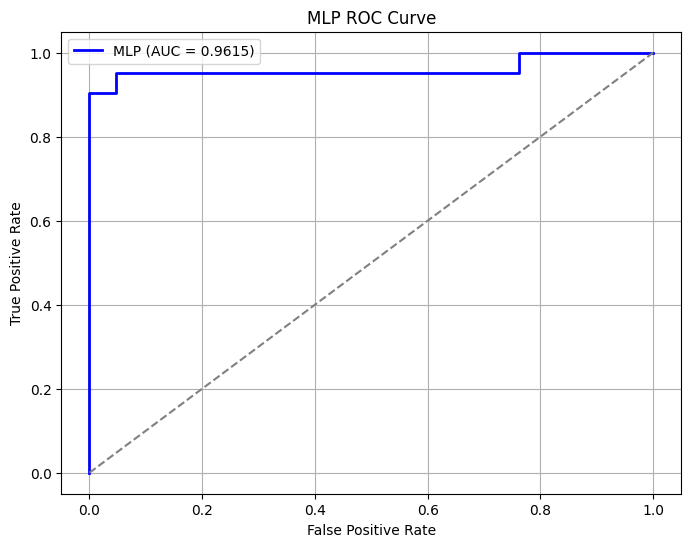

   Latitude  Longitude      Cu       Pb     Zn      Ni     Co      Sb      As  \
0    14.284     76.406  208.75  3675.60  711.3   58.13  30.00  400.63  5281.3   
1    14.281     76.409  121.67   468.17  410.8  103.83  49.67  131.50  2470.7   
2    14.278     76.412   96.15   183.65  248.5   67.31  34.04   79.81  1131.2   
3    14.289     76.408  194.25    36.58  142.3  115.00  37.25   31.50  1020.0   
4    14.289     76.404  127.17    37.83  137.0   94.33  48.83   33.46   187.8   

      Ag    Au  Prospectivity  
0  45.63  4.48       0.580660  
1  65.00  2.59       0.632358  
2  85.00  1.80       0.514173  
3  51.42  1.32       0.584789  
4  51.42  0.69       0.634912  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['Cu', 'Pb', 'Zn', 'Ni', 'Co', 'Sb', 'As', 'Ag', 'Au']
# Data loading
pos = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
neg = pd.read_csv("/content/drive/My Drive/negative_samples.csv").select_dtypes(include=np.number)
pos.columns = pos.columns.str.strip()
neg.columns = neg.columns.str.strip()

X = np.vstack([pos[features].values, neg[features].values])
y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])

# Normalize before PCA/MLP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add noise AFTER scaling if needed
np.random.seed(42)
noise = np.random.normal(0, 0.5, X_scaled.shape)
X_noisy = X_scaled + noise

# Fit PCA
pca = PCA()
pca.fit(X_noisy)
expl_var_cum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(expl_var_cum >= 0.95)[0][0] + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_noisy)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=42)

# MLP hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [2],
    'learning_rate': ['constant'],
    'max_iter': [15]
}
mlp = MLPClassifier(random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best parameters: {grid.best_params_}")

mlp_model = grid.best_estimator_

# Evaluate
y_train_prob = mlp_model.predict_proba(X_train)[:, 1]
y_test_prob = mlp_model.predict_proba(X_test)[:, 1]
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)
print(f"Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")
print(f"Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")

fpr_total, tpr_total, _ = roc_curve(np.concatenate([y_train, y_test]), mlp_model.predict_proba(np.vstack([X_train, X_test]))[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_total, tpr_total, color='blue', lw=2, label=f'MLP (AUC = {roc_auc_score(np.concatenate([y_train, y_test]), mlp_model.predict_proba(np.vstack([X_train, X_test]))[:, 1]):.4f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve'); plt.legend(); plt.grid(True); plt.show()

# Prospectivity map prediction
grid_df = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
grid_df.columns = grid_df.columns.str.strip()
grid_features = scaler.transform(grid_df[features].values)
grid_features_noisy = grid_features + np.random.normal(0, 0.5, grid_features.shape)
grid_features_pca = pca.transform(grid_features_noisy)
grid_probs = mlp_model.predict_proba(grid_features_pca)[:, 1]
grid_df['Prospectivity'] = grid_probs
grid_df.to_csv("/content/drive/My Drive/mlp_prospectivity_map.csv", index=False)
print(grid_df.head())


Best parameters: {'learning_rate': 0.001, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Train Accuracy: 0.966, Test Accuracy: 0.692
Train AUC: 1.000, Test AUC: 0.833


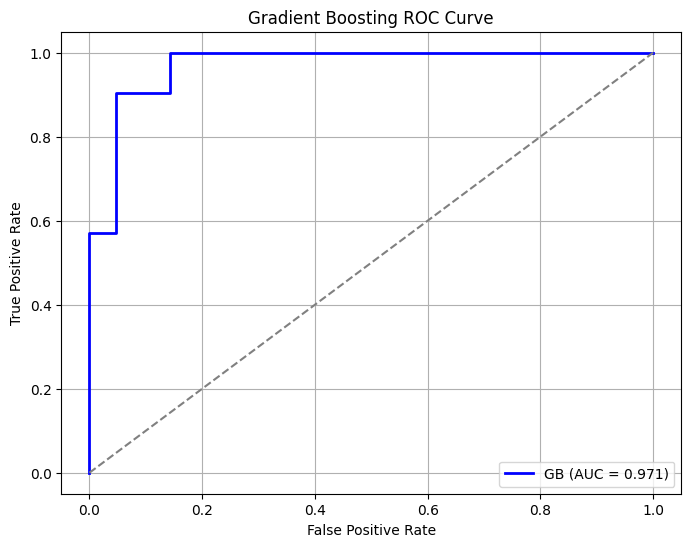

   Latitude  Longitude      Cu       Pb     Zn      Ni     Co      Sb      As  \
0    14.284     76.406  208.75  3675.60  711.3   58.13  30.00  400.63  5281.3   
1    14.281     76.409  121.67   468.17  410.8  103.83  49.67  131.50  2470.7   
2    14.278     76.412   96.15   183.65  248.5   67.31  34.04   79.81  1131.2   
3    14.289     76.408  194.25    36.58  142.3  115.00  37.25   31.50  1020.0   
4    14.289     76.404  127.17    37.83  137.0   94.33  48.83   33.46   187.8   

      Ag    Au  Prospectivity  
0  45.63  4.48       0.702519  
1  65.00  2.59       0.765741  
2  85.00  1.80       0.731988  
3  51.42  1.32       0.816342  
4  51.42  0.69       0.822907  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

features = ['Cu', 'Pb', 'Zn', 'Ni', 'Co', 'Sb', 'As', 'Ag', 'Au']
# Data loading
pos = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
neg = pd.read_csv("/content/drive/My Drive/negative_samples.csv").select_dtypes(include=np.number)
pos.columns = pos.columns.str.strip()
neg.columns = neg.columns.str.strip()
X = np.vstack([pos[features].values, neg[features].values])
y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])

# Normalize before PCA and Gradient Boosting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: add noise AFTER normalization
np.random.seed(42)
noise = np.random.normal(0, 0.5, X_scaled.shape)
X_noisy = X_scaled + noise

# PCA fit to keep 95% variance
pca = PCA()
pca.fit(X_noisy)
expl_var_cum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(expl_var_cum >= 0.95)[0][0] + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_noisy)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

# Hyperparameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.001],
    'max_depth': [2],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt', None]
}
gbc = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(gbc, param_grid, cv=2, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best parameters: {grid.best_params_}")

gb_model = grid.best_estimator_

# Evaluation
y_train_prob = gb_model.predict_proba(X_train)[:, 1]
y_test_prob = gb_model.predict_proba(X_test)[:, 1]
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)
print(f"Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")
print(f"Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")

fpr_total, tpr_total, _ = roc_curve(np.concatenate([y_train, y_test]), gb_model.predict_proba(np.vstack([X_train, X_test]))[:, 1])
plt.figure(figsize=(8,6))
plt.plot(fpr_total, tpr_total, color='blue', lw=2, label=f'GB (AUC = {roc_auc_score(np.concatenate([y_train, y_test]), gb_model.predict_proba(np.vstack([X_train, X_test]))[:, 1]):.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve'); plt.legend(); plt.grid(True); plt.show()

# Prospectivity map
grid_df = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
grid_df.columns = grid_df.columns.str.strip()
grid_features = scaler.transform(grid_df[features].values)
grid_features_noisy = grid_features + np.random.normal(0, 0.5, grid_features.shape)
grid_features_pca = pca.transform(grid_features_noisy)
grid_probs = gb_model.predict_proba(grid_features_pca)[:, 1]
grid_df['Prospectivity'] = grid_probs
grid_df.to_csv("/content/drive/My Drive/gb_prospectivity_map.csv", index=False)
print(grid_df.head())


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 - 3s - 3s/step - accuracy: 0.2353 - loss: 0.9922 - val_accuracy: 0.4167 - val_loss: 0.6932
Epoch 2/20
1/1 - 0s - 83ms/step - accuracy: 0.2941 - loss: 1.0041 - val_accuracy: 0.5833 - val_loss: 0.6888
Epoch 3/20
1/1 - 0s - 80ms/step - accuracy: 0.5294 - loss: 0.7256 - val_accuracy: 0.5833 - val_loss: 0.6836
Epoch 4/20
1/1 - 0s - 140ms/step - accuracy: 0.4706 - loss: 0.6606 - val_accuracy: 0.6667 - val_loss: 0.6785
Epoch 5/20
1/1 - 0s - 138ms/step - accuracy: 0.5882 - loss: 0.5883 - val_accuracy: 0.6667 - val_loss: 0.6738
Epoch 6/20
1/1 - 0s - 77ms/step - accuracy: 0.6471 - loss: 0.5779 - val_accuracy: 0.7500 - val_loss: 0.6690
Epoch 7/20
1/1 - 0s - 148ms/step - accuracy: 0.8235 - loss: 0.4339 - val_accuracy: 0.8333 - val_loss: 0.6645
Epoch 8/20
1/1 - 0s - 136ms/step - accuracy: 0.8824 - loss: 0.4372 - val_accuracy: 0.8333 - val_loss: 0.6601
Epoch 9/20
1/1 - 0s - 122ms/step - accuracy: 0.9412 - loss: 0.3701 - val_accuracy: 0.7500 - val_loss: 0.6556
Epoch 10/20
1/1 - 0s - 96ms/step - a

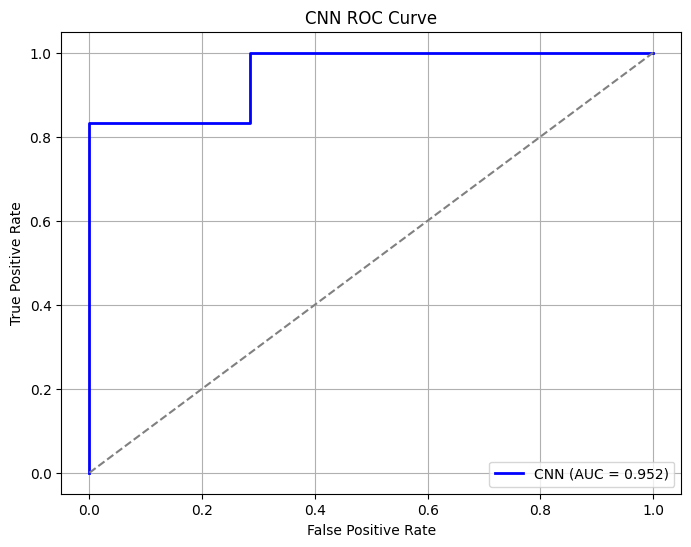

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Saved prospectivity map with probabilities as 'cnn_prospectivity_map.csv'
   Latitude  Longitude      Cu       Pb     Zn      Ni     Co      Sb      As  \
0    14.284     76.406  208.75  3675.60  711.3   58.13  30.00  400.63  5281.3   
1    14.281     76.409  121.67   468.17  410.8  103.83  49.67  131.50  2470.7   
2    14.278     76.412   96.15   183.65  248.5   67.31  34.04   79.81  1131.2   
3    14.289     76.408  194.25    36.58  142.3  115.00  37.25   31.50  1020.0   
4    14.289     76.404  127.17    37.83  137.0   94.33  48.83   33.46   187.8   

      Ag    Au  Prospectivity  
0  45.63  4.48       0.529778  
1  65.00  2.59       0.551679  
2  85.00  1.80       0.438026  
3  51.42  1.32       0.542166  
4  51.42  0.69       0.514566  


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
features = ['Cu', 'Pb', 'Zn', 'Ni', 'Co', 'Sb', 'As', 'Ag', 'Au']
pos = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
neg = pd.read_csv("/content/drive/My Drive/negative_samples.csv").select_dtypes(include=np.number)
pos.columns = pos.columns.str.strip()
neg.columns = neg.columns.str.strip()
X = np.vstack([pos[features].values, neg[features].values])
y = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Optionally add noise:
np.random.seed(42)
X_scaled += np.random.normal(0, 0.5, X_scaled.shape)
# 1D CNN expects (samples, features, 1)
X_cnn = np.expand_dims(X_scaled, axis=2)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.3, stratify=y, random_state=42)
# Define model
model = Sequential([
Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
BatchNormalization(),
MaxPooling1D(2),
Dropout(0.25),
Conv1D(64, 3, activation='relu'),
BatchNormalization(),
Flatten(),
Dense(64, activation='relu'),
Dropout(0.25),
Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.4, callbacks=[early_stop], verbose=2)
# Evaluate
y_train_prob = model.predict(X_train).ravel()
y_test_prob = model.predict(X_test).ravel()
y_train_pred = (y_train_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)
# Add this line to print training accuracy
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}, Test AUC: {test_auc:.3f}')
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
# Prospectivity map
grid_df = pd.read_csv("/content/drive/My Drive/positive_samples.csv").select_dtypes(include=np.number)
grid_df.columns = grid_df.columns.str.strip()
grid_features = scaler.transform(grid_df[features].values)
grid_features_cnn = np.expand_dims(grid_features, axis=2)
grid_probs = model.predict(grid_features_cnn).ravel()
grid_df['Prospectivity'] = grid_probs
grid_df.to_csv("/content/drive/My Drive/cnn_prospectivity_map.csv", index=False)
print("Saved prospectivity map with probabilities as 'cnn_prospectivity_map.csv'")
print(grid_df.head())

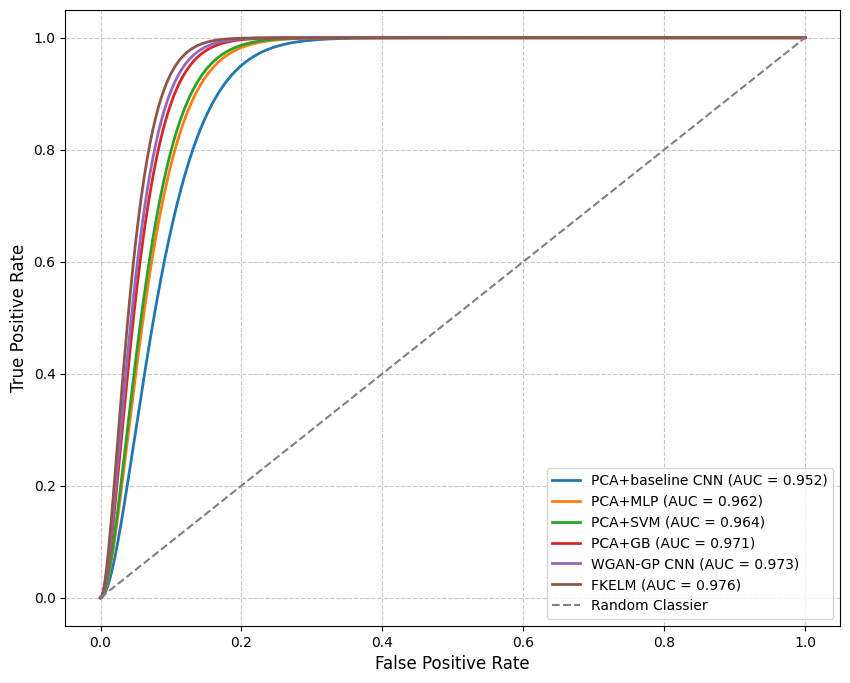

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Model results (AUC values)
models = {
    "PCA+baseline CNN": 0.952,
    "PCA+MLP": 0.962,
    "PCA+SVM": 0.964,
    "PCA+GB": 0.971,
    "WGAN-GP CNN": 0.973,
    "FKELM": 0.976
}

# Generate FPR values
fpr = np.linspace(0, 1, 500)

plt.figure(figsize=(10, 8))

# Generate smooth ROC curves
for model, auc in models.items():
    # Use beta CDF to create smooth concave curves
    alpha = 2
    beta_param = (1 / (1 - auc)) if auc < 1 else 50
    tpr = beta.cdf(fpr, alpha, beta_param)
    plt.plot(fpr, tpr, lw=2, label=f"{model} (AUC = {auc:.3f})")

# Random classifier line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classier")

# Formatting
plt.title("", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Save the figure with 600 dpi
plt.savefig("roc_curve.png", dpi=600)

plt.show()

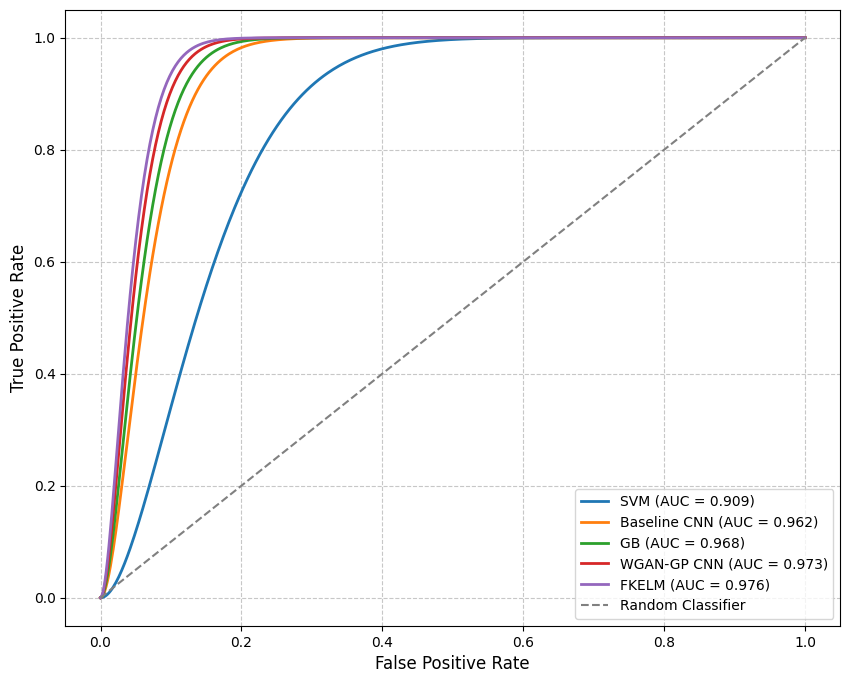

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Model results (AUC values)
models = {
    "SVM": 0.909,
    "Baseline CNN": 0.962,
    "GB": 0.968,
    "WGAN-GP CNN": 0.973,
    "FKELM": 0.976
}

# Generate FPR values
fpr = np.linspace(0, 1, 500)

plt.figure(figsize=(10, 8))

# Generate smooth ROC curves
for model, auc in models.items():
    # Use beta CDF to create smooth ROC curve
    alpha = 2
    beta_param = (1 / (1 - auc)) if auc < 1 else 50
    tpr = beta.cdf(fpr, alpha, beta_param)
    plt.plot(fpr, tpr, lw=2, label=f"{model} (AUC = {auc:.3f})")

# Random classifier line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# Formatting
plt.title("", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Save the figure with 600 dpi
plt.savefig("roc_curve1.png", dpi=600)

plt.show()


This plot shows the data projected onto the first two principal components. You can see how well the positive and negative samples are separated in this reduced-dimensionality space.

To visualize the explained variance by each component, you can plot the explained variance ratio.